In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

from FSC import GenerationContinuousObs as FSC_ContinuousObs
from FSC import InferenceContinuousObs as FSC_InferenceContinuousObs

import numba as nb
import pandas as pd

import networkx as nx

In [398]:
def plot_network(ax, piprob, pitilde_prob,
                 memory1_color='gray', memory2_color='gray',
                 action_r_color='lightblue', action_t_color='salmon',
                 figsize=(10, 3), title=""):
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add memory nodes
    G.add_node('$M_1$', shape='o', color=memory1_color)
    G.add_node('$M_2$', shape='o', color=memory2_color)
    
    # Add action nodes
    G.add_node('R1', shape='s', color=action_r_color)
    G.add_node('T1', shape='s', color=action_t_color)
    G.add_node('R2', shape='s', color=action_r_color)
    G.add_node('T2', shape='s', color=action_t_color)
    
    # Add edges from memory nodes to action nodes
    G.add_edges_from([('$M_1$', 'R1'), ('$M_1$', 'T1'),
                      ('$M_2$', 'R2'), ('$M_2$', 'T2')])
    
    # Add edges from action nodes to memory nodes
    G.add_edges_from([('R1', '$M_1$'), ('R1', '$M_2$'),
                      ('T1', '$M_1$'), ('T1', '$M_2$'),
                      ('R2', '$M_1$'), ('R2', '$M_2$'),
                      ('T2', '$M_1$'), ('T2', '$M_2$')])
    
    # Define node shapes
    node_shapes = {'o': 'o', 's': 's'}
    
    # Define custom labels for plotting
    labels = {'$M_1$': '$M_1$', '$M_2$': '$M_2$', 'R1': 'R', 'T1': 'T', 'R2': 'R', 'T2': 'T'}
    
    # Define positions for the nodes
    pos = {
        '$M_1$': (0, 0),
        'R1': (0.2, 1),
        'T1': (0.2, -1),
        '$M_2$': (2, 0),
        'R2': (1.8, 1),
        'T2': (1.8, -1)
    }

    ax.axis('off')
    
    # Draw the graph
    for shape in node_shapes:
        nodes = [n for n in G.nodes if G.nodes[n]['shape'] == shape]
        colors = [G.nodes[n]['color'] for n in nodes]
        node_size = 2000 if shape == 'o' else 400  # Larger size for memory nodes, smaller for action nodes
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=node_shapes[shape],
                               node_size=node_size, node_color=colors, ax=ax)
    
    # Draw edges with arrows and curved connections
    memory_to_action_edges_left = [('$M_2$', 'R2', piprob[1, 0]), ('$M_1$', 'T1', piprob[0, 1])]
    memory_to_action_edges_right = [('$M_1$', 'R1', piprob[0, 0]), ('$M_2$', 'T2', piprob[1, 1])]
    memory_to_action_edges = [memory_to_action_edges_left, memory_to_action_edges_right]

    action_to_memory_stay_edges_1 = [('R1', '$M_1$', pitilde_prob[0, 0, 0]), ('T2', '$M_2$', pitilde_prob[1, 1, 1])]
    action_to_memory_stay_edges_2 = [('R2', '$M_2$', pitilde_prob[1, 1, 0]), ('T1', '$M_1$', pitilde_prob[0, 0, 1])]

    action_to_memory_stay_edges = [action_to_memory_stay_edges_1, action_to_memory_stay_edges_2]

    action_to_memory_edges = [('R1', '$M_2$', pitilde_prob[0, 1, 0]), ('T1', '$M_2$', pitilde_prob[0, 1, 1]),
                              ('R2', '$M_1$', pitilde_prob[1, 0, 0]), ('T2', '$M_1$', pitilde_prob[1, 0, 1])]
    
    # Draw edges with different colors and connection styles

    xshifts = {'$M_1$': -0.33, '$M_2$': 0.18}
    pscale = 5
    rads = [0.5, -0.5]

    for i in range(len(memory_to_action_edges)):
        for j, (u, v, prob) in enumerate(memory_to_action_edges[i]):
            width = prob * pscale

            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rads[i]}', width=width,
                                arrows=True, arrowsize=20, min_source_margin=25, min_target_margin=15, edge_color='gray', ax=ax)
            
            x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
            y = (pos[u][1] + pos[v][1]) / 2
            ax.text(x, y, f'{prob:.3f}', fontsize=10, color='gray')

    rads = [-0.2, 0.2]
    xshifts = {'R1': 0.1, 'T1': 0.08, 'R2': -0.27, 'T2': -0.25}
    yshifts = {'R1': 0.08, 'T1': -0., 'R2': 0., 'T2': -0.15}
    colors = {'R1': 'lightblue', 'T1': 'salmon', 'R2': 'lightblue', 'T2': 'salmon'}

    for i in range(len(action_to_memory_stay_edges)):
        for j, (u, v, prob) in enumerate(action_to_memory_stay_edges[i]):
            width = prob * pscale

            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rads[i]}', width=width,
                                   arrows=True, arrowsize=20, min_source_margin=15, min_target_margin=25, edge_color=colors[u], ax=ax)
            
            x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
            y = (pos[u][1] + pos[v][1]) / 2 + yshifts[u]
            ax.text(x, y, f'{prob:.3f}', fontsize=10, color=colors[u])

    xshifts = {'R1': 0., 'T1': -0.5, 'R2': -0.27, 'T2': -0.3}
    yshifts = {'R1': -0.35, 'T1': -0.45, 'R2': 0.45, 'T2': 0.58}

    for i, (u, v, prob) in enumerate(action_to_memory_edges):
        width = prob * pscale

        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle='arc3,rad=0.2', width=width,
                               arrows=True, arrowsize=20, min_source_margin=15, min_target_margin=25, edge_color=colors[u], ax=ax)
        
        x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
        y = (pos[u][1] + pos[v][1]) / 2 + yshifts[u]

        ax.text(x, y, f'{prob:.3f}', fontsize=10, color=colors[u])
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='white', ax=ax)
    
    # Add title
    ax.set_title(title)

    cut = 1.1
    xmax= cut*max(xx for xx,yy in pos.values())
    ax.set_xlim(-0.2,xmax)

In [399]:
path = "../data/data_filtered"
df = pd.read_csv(path)

In [400]:
cell_indexes = np.unique(df["particle"])
cell_indexes.size

3485

In [401]:
actions = []
frames = []
observations = []

for cell_idx in cell_indexes:
    cell = df[df["particle"] == cell_idx]

    actions.append(cell["tumbling"].values)
    frames.append(cell["frame"].values)
    observations.append(cell["c_norm"].values)

NCutStart = 1000
NCutEnd = 2000

actions = [actions[i] for i in range(NCutStart, NCutEnd)]
frames = [frames[i] for i in range(NCutStart, NCutEnd)]
observations = [observations[i] for i in range(NCutStart, NCutEnd)]

In [402]:
trajectories = []

for i in range(NCutEnd - NCutStart):
    dict_traj = {}
    dict_traj["actions"] = actions[i].astype(int)
    dict_traj["features"] = np.array([np.ones(observations[i].size).astype(np.float32), observations[i].astype(np.float32)])

    trajectories.append(dict_traj)

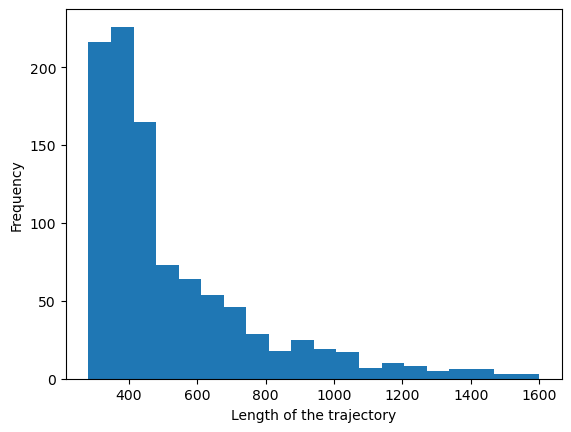

In [403]:
plt.hist([len(tr["actions"]) for tr in trajectories], bins=20)
plt.xlabel("Length of the trajectory")
plt.ylabel("Frequency")
plt.show()

In [496]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8]

F = 2
M = 2
A = 2

theta_list = []
psi_list = []
tloss_list = []
vloss_list = []

for seed in seeds:
    par_name = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_seed_{seed}_NTrajs{len(trajectories)}_NCutStart{NCutStart}_NCutEnd{NCutEnd}_"

    theta_list.append(np.load(par_name + "theta.npy"))
    psi_list.append(np.load(par_name + "psi.npy"))
    tloss_list.append(np.load(par_name + "tloss.npy"))
    vloss_list.append(np.load(par_name + "vloss.npy"))

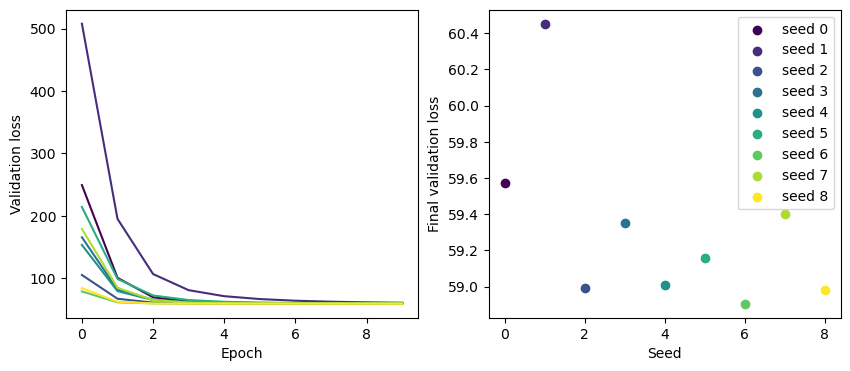

In [497]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

colors = plt.cm.viridis(np.linspace(0, 1, len(seeds)))

for i, vl in enumerate(vloss_list):
    ax[0].plot(vl, c = colors[i], label=f"seed {i}")
    ax[1].scatter(i, vl[-1], color = colors[i], label=f"seed {i}")

ax[0].set_ylabel("Validation loss")
ax[0].set_xlabel("Epoch")

ax[1].set_ylabel("Final validation loss")
ax[1].set_xlabel("Seed")

plt.legend()
plt.show()

Seed 1
Average overall loss 58.29753982747378
Initial distribution of memories [0.04315771 0.95684229]
Mutual information 1.3615142083071028e-05
Mutual information 0.00013037436306738925


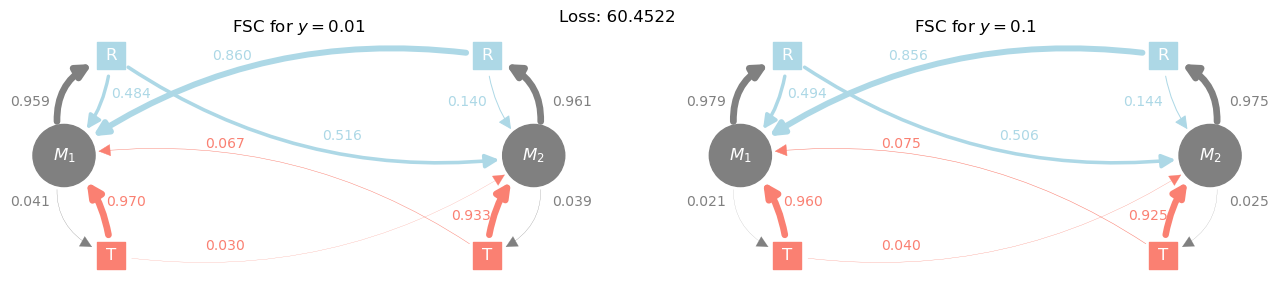

Seed 0
Average overall loss 57.3723231896447
Initial distribution of memories [0.02564198 0.97435802]
Mutual information 0.022909620790617147
Mutual information 0.027013309779551877


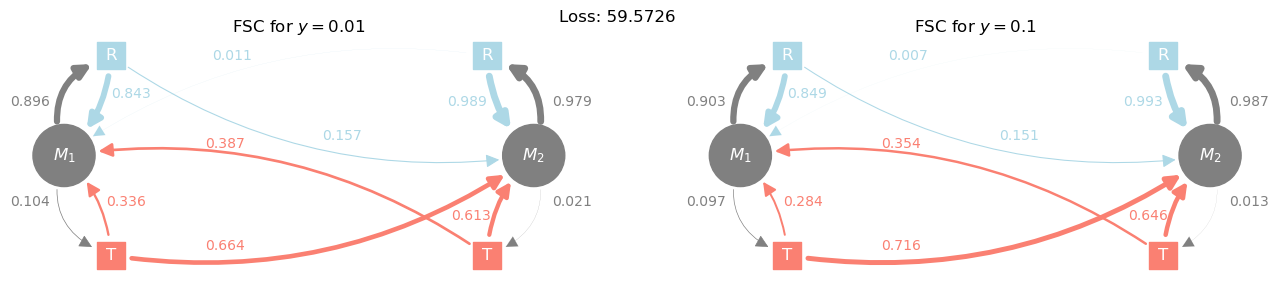

Seed 7
Average overall loss 57.20489444698561
Initial distribution of memories [0.0141674 0.9858326]
Mutual information 0.015750201561320162
Mutual information 0.011826954277545446


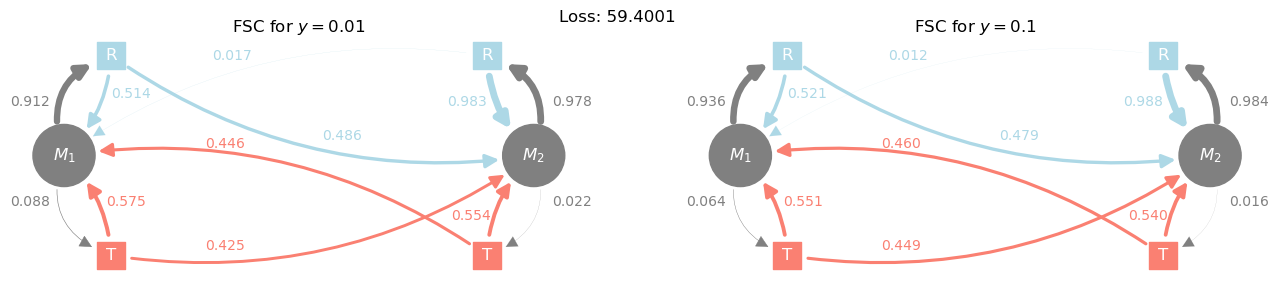

Seed 3
Average overall loss 57.157403077170954
Initial distribution of memories [0.02240797 0.97759203]
Mutual information 0.005732569642113449
Mutual information 0.0056342473796981395


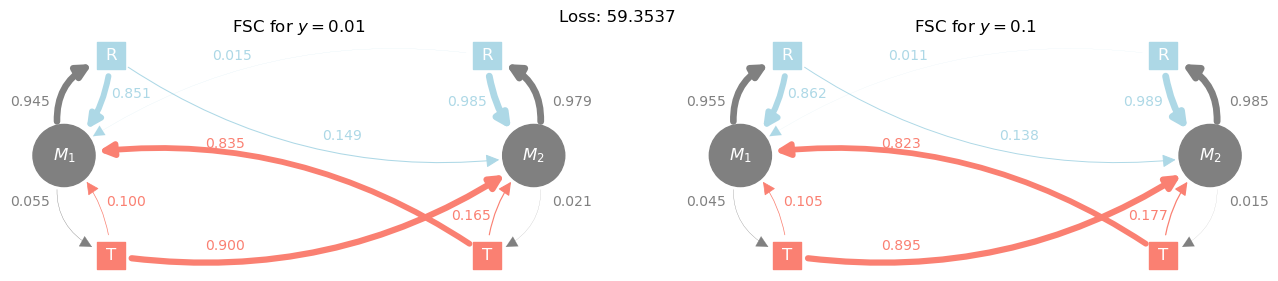

Seed 5
Average overall loss 56.99426867122588
Initial distribution of memories [0.07986296 0.92013704]
Mutual information 0.00010203359138183832
Mutual information 2.682367258459808e-06


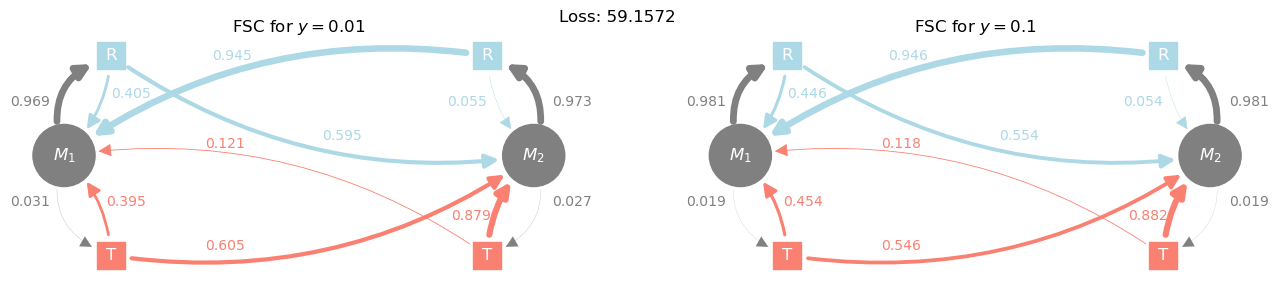

Seed 4
Average overall loss 56.83575028959271
Initial distribution of memories [0.02233301 0.97766699]
Mutual information 0.0011341992570459238
Mutual information 0.0002043180955802412


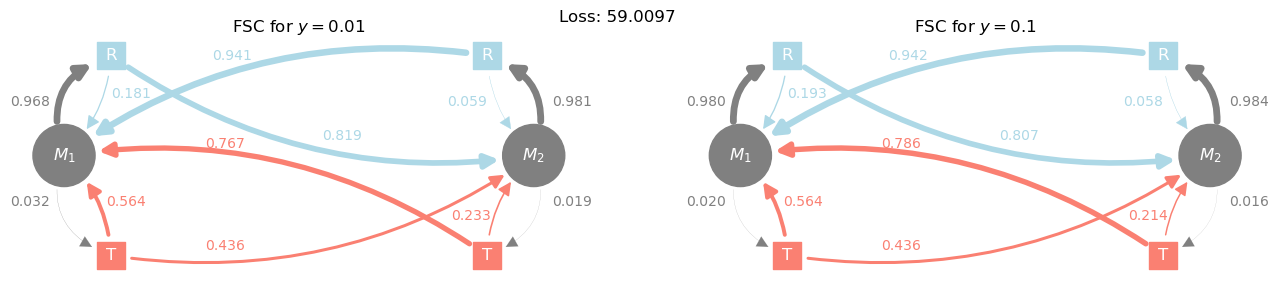

Seed 2
Average overall loss 56.80687720223969
Initial distribution of memories [0.9754128 0.0245872]
Mutual information 0.0016266419768980085
Mutual information 0.0008576855954848797


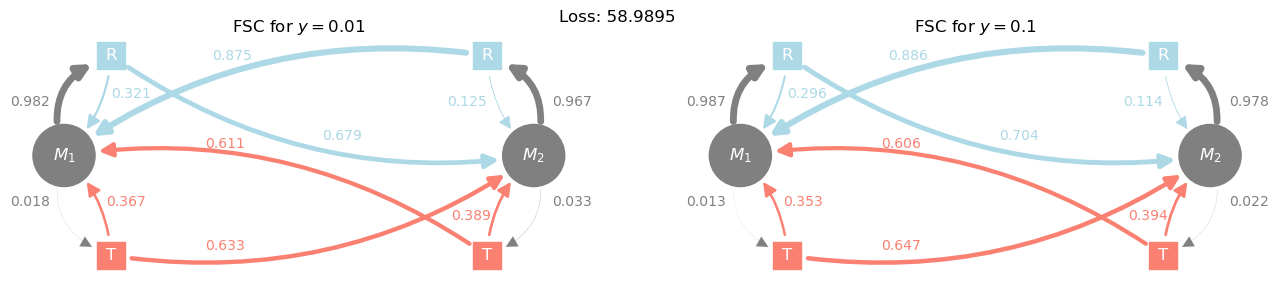

Seed 8
Average overall loss 56.79750663542208
Initial distribution of memories [0.04394428 0.95605572]
Mutual information 0.0010438917911113235
Mutual information 0.0005245035288355942


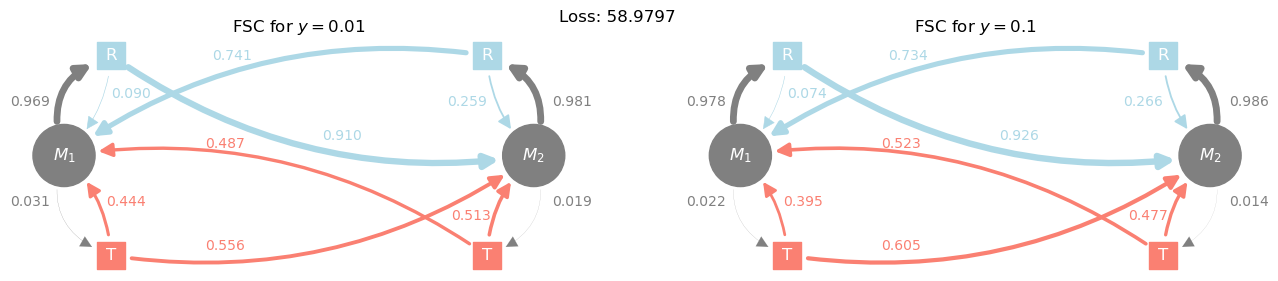

Seed 6
Average overall loss 56.73506905040932
Initial distribution of memories [0.12788942 0.87211058]
Mutual information 0.0003599161476468501
Mutual information 0.0009643621217847271


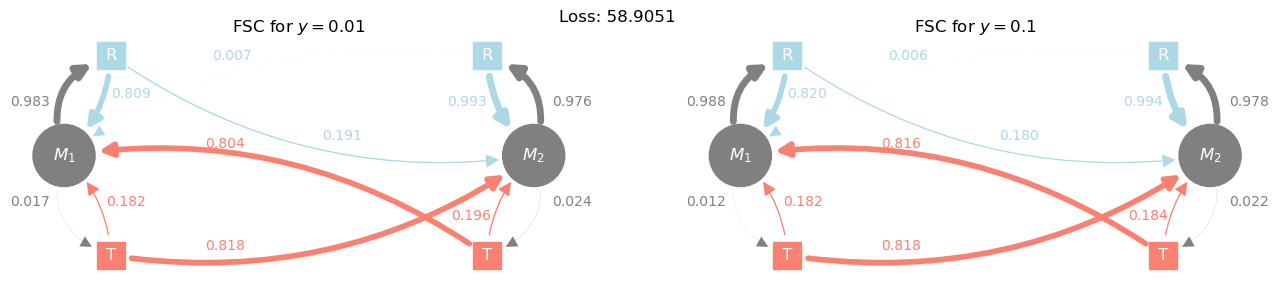

In [500]:
c_array = np.array([1e-2, 1e-1])
feature_array = np.array([np.ones(c_array.size), c_array])

sorted_seeds_idx = np.argsort([vl[-1] for vl in vloss_list])[::-1]

for idx_seed_srt in sorted_seeds_idx:
    idx_seed = seeds[idx_seed_srt]
    print(f"Seed {idx_seed}")

    FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = False)
    FSC_inferred.load_features([tr["features"] for tr in trajectories])

    TMat_array = FSC_inferred.get_TMat(feature_array)

    pi_prob = TMat_array.sum(axis = 2)
    pitilde_prob = TMat_array/pi_prob[:, :, None, :]

    nLL = 0

    for trj in trajectories:
        nLL += FSC_inferred.evaluate_nloglikelihood(trj)

    print("Average overall loss", nLL/len(trajectories))
    print("Initial distribution of memories", FSC_inferred.rho)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

    idx_y = 0
    joint = pi_prob[idx_y]*np.ones(M)[..., None]/M
    pA = np.sum(joint, axis = 0)
    pM = np.sum(joint, axis = 1)

    log_arg = joint / (pA[None, :] * pM[:, None])

    print("Mutual information", np.sum(joint * np.log2(log_arg)))
    plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

    idx_y = -1
    joint = pi_prob[idx_y]*np.ones(M)[..., None]/M
    pA = np.sum(joint, axis = 0)
    pM = np.sum(joint, axis = 1)

    log_arg = joint / (pA[None, :] * pM[:, None])

    print("Mutual information", np.sum(joint * np.log2(log_arg)))

    plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

    overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
    fig.suptitle(overall_title, fontsize=12)

    plt.subplots_adjust(wspace=0.2)
    plt.show()

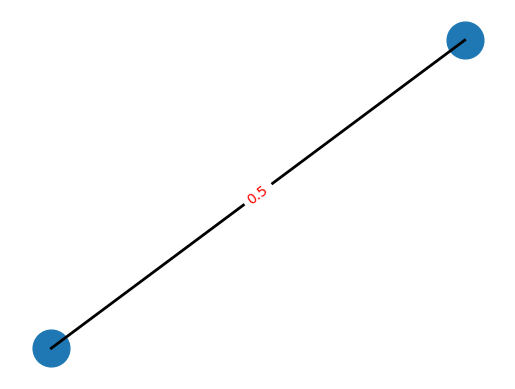

In [431]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('A')
G.add_node('B')

# Add an edge
G.add_edge('A', 'B')

# Define positions for the nodes
pos = {'A': (0, 0), 'B': (1, 1)}

# Create the plot
fig, ax = plt.subplots()

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

# Draw edge labels
edge_labels = {('A', 'B'): '0.5'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', ax=ax)

# Draw the interrupted edge manually
x1, y1 = pos['A']
x2, y2 = pos['B']
mid_x = (x1 + x2) / 2
mid_y = (y1 + y2) / 2
gap = 0.05  # Adjust the gap size as needed

# Calculate the direction vector of the edge
dx = x2 - x1
dy = y2 - y1
length = (dx**2 + dy**2)**0.5
ux = dx / length
uy = dy / length

# Draw the two segments of the edge
line1 = plt.Line2D([x1, mid_x - gap * ux], [y1, mid_y - gap * uy], color='black', linewidth=2)
line2 = plt.Line2D([mid_x + gap * ux, x2], [mid_y + gap * uy, y2], color='black', linewidth=2)
ax.add_line(line1)
ax.add_line(line2)

# Set axis limits and remove axis
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.axis('off')

plt.show()

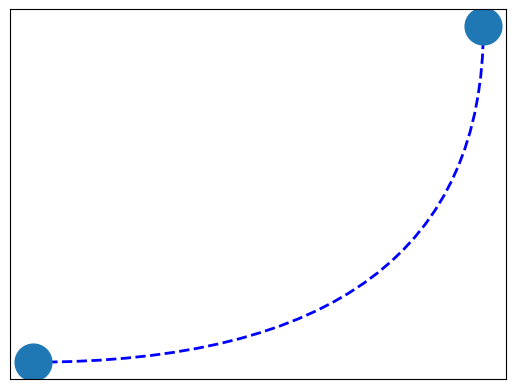

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('A')
G.add_node('B')

# Add an edge
G.add_edge('A', 'B')

# Define positions for the nodes
pos = {'A': (0, 0), 'B': (1, 1)}

# Create the plot
fig, ax = plt.subplots()

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, ax=ax)

# Draw the original curved edge for reference
x1, y1 = pos['A']
x2, y2 = pos['B']

# Calculate control points for the Bezier curve
control_x = (x1 + x2) / 2 + 0.5  # Adjust the control point for curvature
control_y = (y1 + y2) / 2 - 0.5

# Create the Bezier curve path
vertices = [(x1, y1), (control_x, control_y), (x2, y2)]
codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
path = Path(vertices, codes)

# Draw the original curved edge
patch = PathPatch(path, edgecolor='blue', facecolor='none', linewidth=2, linestyle='dashed')
ax.add_patch(patch)

# draw patch again, but clipping it in 


# First seed

Initializing FSC with 2 memory states, 2 actions, and 2 features.


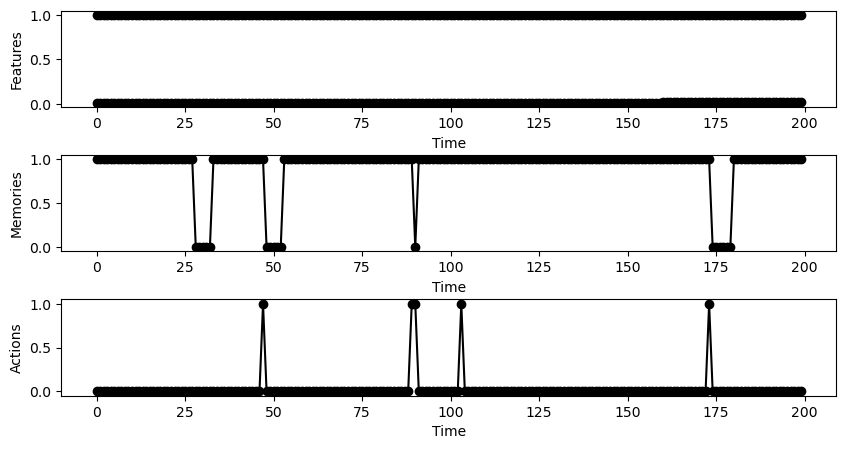

In [339]:
idx_seed = 0
FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = True)

FSC_inferred.load_features([tr["features"] for tr in trajectories])

NSteps = 200
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

In [340]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

pi_prob = TMat_array.sum(axis = 2)
pitilde_prob = TMat_array/pi_prob[:, :, None, :]

[0.79147851 0.20852149]
[0.01591591 0.98408409]


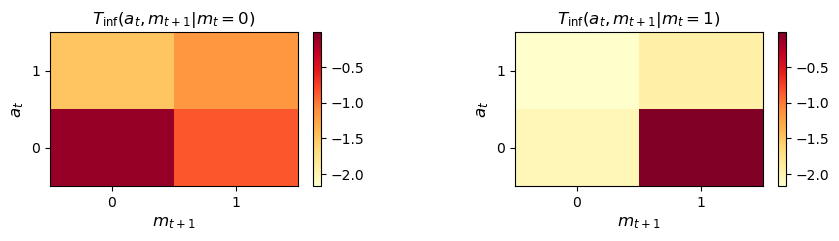

[0.79258923 0.20741077]
[0.01401493 0.98598507]


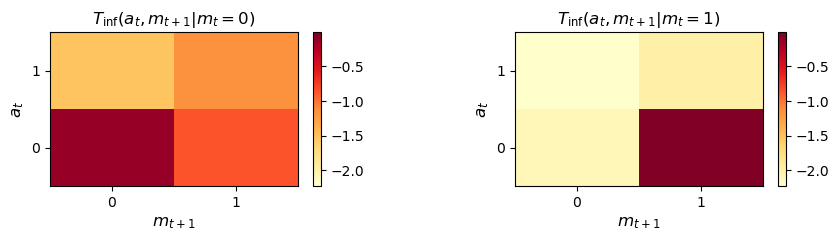

[0.79009926 0.20990074]
[0.01868231 0.98131769]


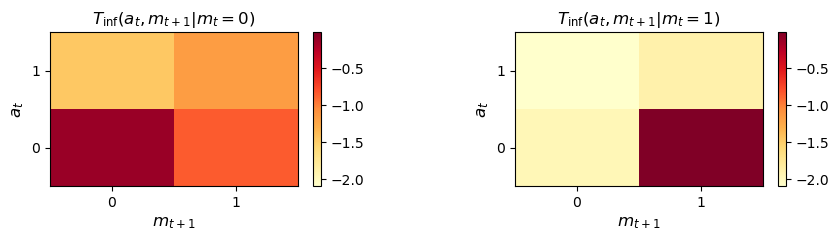

[0.79011519 0.20988481]
[0.01864746 0.98135254]


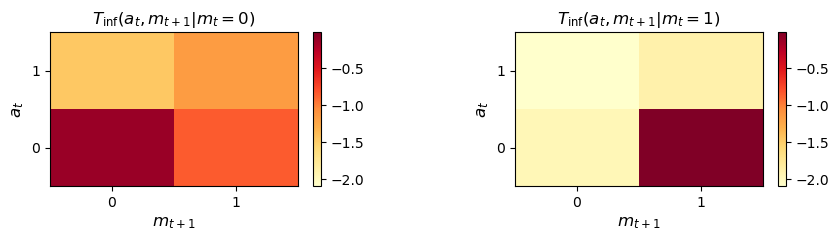

[0.78995452 0.21004548]
[0.01900231 0.98099769]


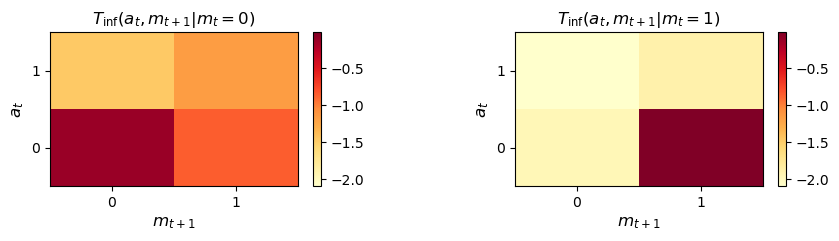

In [341]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20

for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

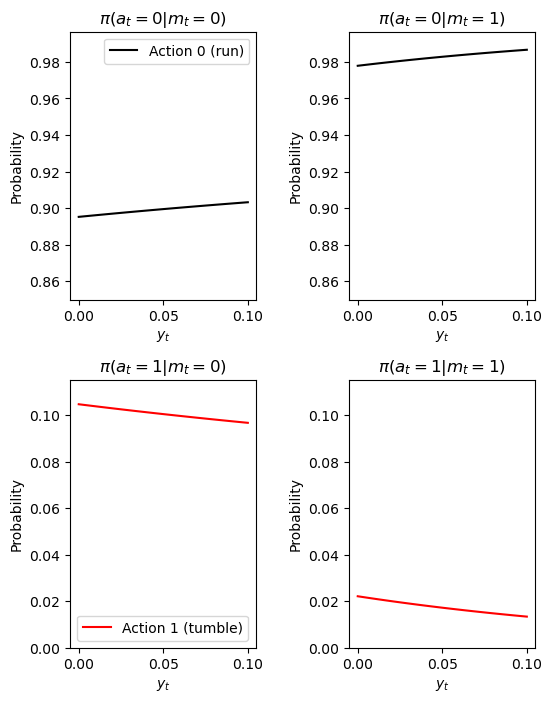

In [342]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

max_p_0 = pi_prob[:, :, 0].max()
max_p_1 = pi_prob[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.85, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, pi_prob[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, pi_prob[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$\\pi(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$y_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

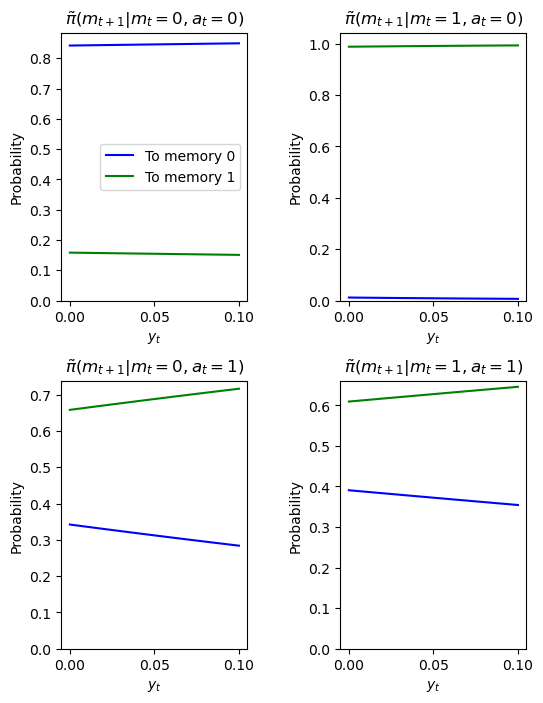

In [343]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_a, a in enumerate(range(A)):
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 0, idx_a], label = f"To memory 0", c = 'b')
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 1, idx_a], label = f"To memory 1", c = 'g')

        ax[idx_a, idx_m].set_title(f"$\\tilde\\pi(m_{{t+1}} | m_t = {m}, a_t = {a})$")
        ax[idx_a, idx_m].set_xlabel("$y_t$")
        ax[idx_a, idx_m].set_ylabel("Probability")
        ax[idx_a, idx_m].set_ylim(0,)

ax[0, 0].legend()

plt.show()

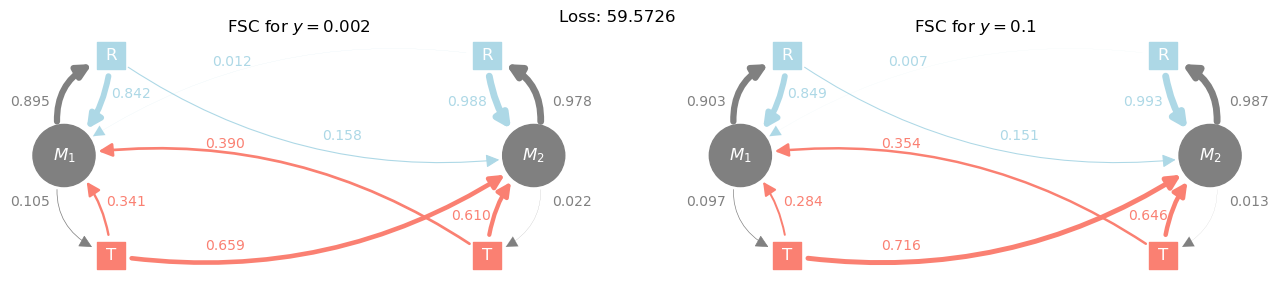

In [344]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

idx_y = 2
plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

idx_y = -1
plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
fig.suptitle(overall_title, fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.show()

# Second seed

Initializing FSC with 2 memory states, 2 actions, and 2 features.


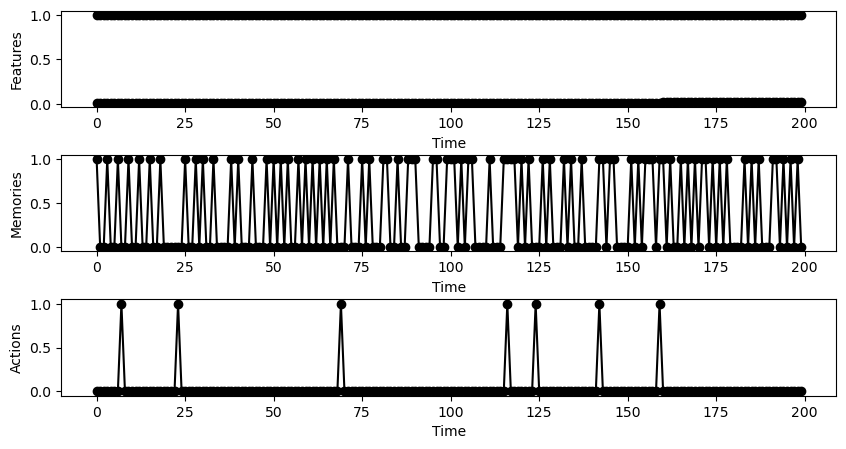

In [345]:
idx_seed = 1
FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = True)

FSC_inferred.load_features([tr["features"] for tr in trajectories])

NSteps = 200
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

In [346]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

pi_prob = TMat_array.sum(axis = 2)
pitilde_prob = TMat_array/pi_prob[:, :, None, :]

[0.50297099 0.49702901]
[0.83234884 0.16765116]


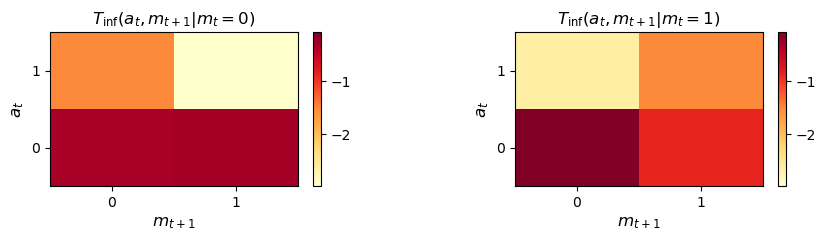

[0.50291829 0.49708171]
[0.83413512 0.16586488]


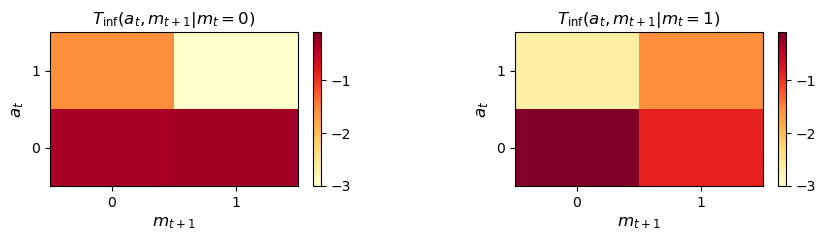

[0.5036864 0.4963136]
[0.82960843 0.17039157]


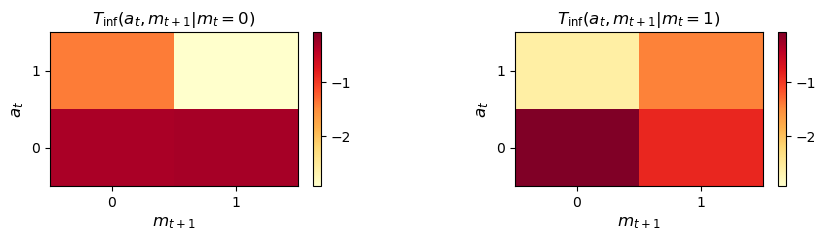

[0.50367336 0.49632664]
[0.82964377 0.17035623]


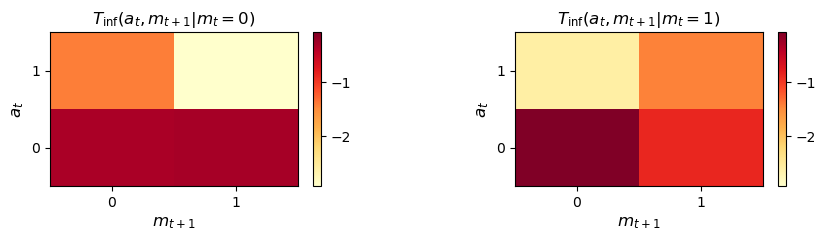

[0.50381038 0.49618962]
[0.82928314 0.17071686]


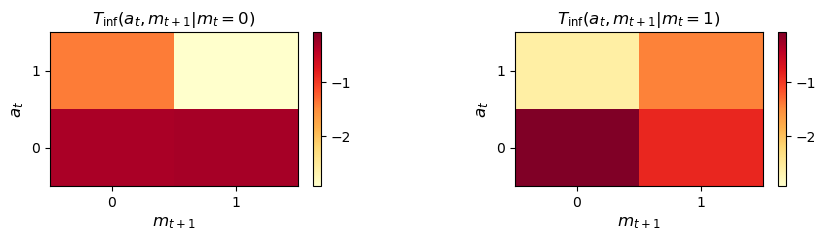

In [347]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20

for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

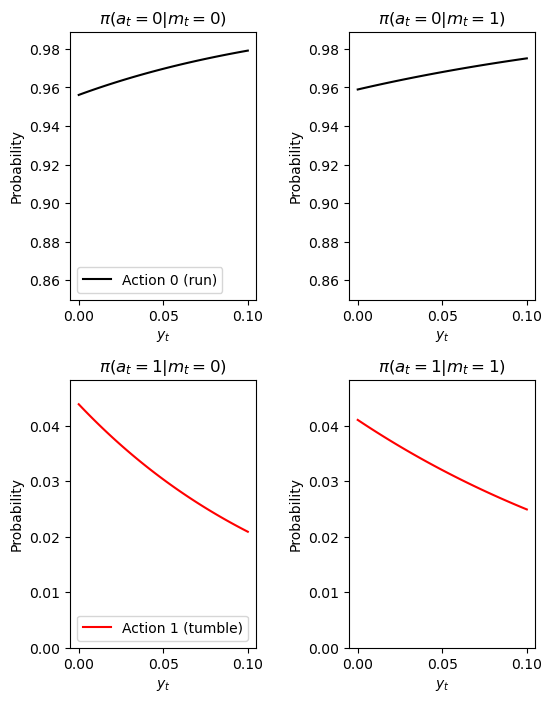

In [348]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

max_p_0 = pi_prob[:, :, 0].max()
max_p_1 = pi_prob[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.85, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, pi_prob[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, pi_prob[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$\\pi(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$y_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

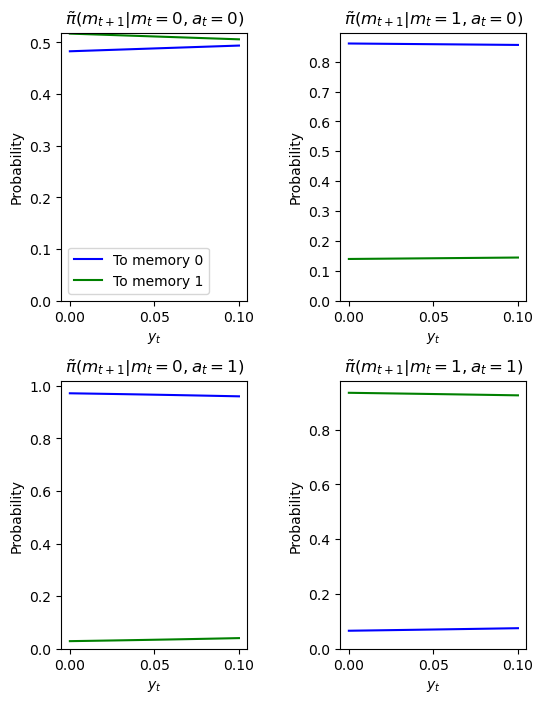

In [349]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_a, a in enumerate(range(A)):
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 0, idx_a], label = f"To memory 0", c = 'b')
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 1, idx_a], label = f"To memory 1", c = 'g')

        ax[idx_a, idx_m].set_title(f"$\\tilde\\pi(m_{{t+1}} | m_t = {m}, a_t = {a})$")
        ax[idx_a, idx_m].set_xlabel("$y_t$")
        ax[idx_a, idx_m].set_ylabel("Probability")
        ax[idx_a, idx_m].set_ylim(0,)

ax[0, 0].legend()

plt.show()

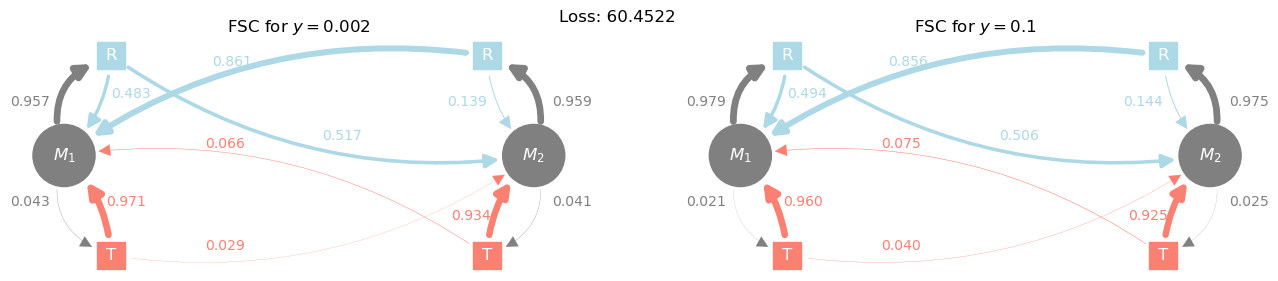

In [350]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

idx_y = 2
plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

idx_y = -1
plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
fig.suptitle(overall_title, fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.show()

# Third seed

Initializing FSC with 2 memory states, 2 actions, and 2 features.


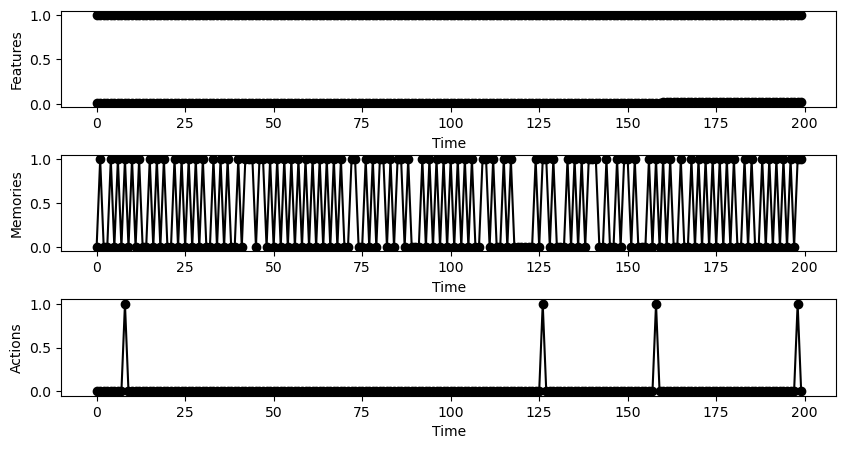

In [351]:
idx_seed = 2
FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = True)

FSC_inferred.load_features([tr["features"] for tr in trajectories])

NSteps = 200
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

In [352]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

pi_prob = TMat_array.sum(axis = 2)
pitilde_prob = TMat_array/pi_prob[:, :, None, :]

[0.31318852 0.68681148]
[0.87105588 0.12894412]


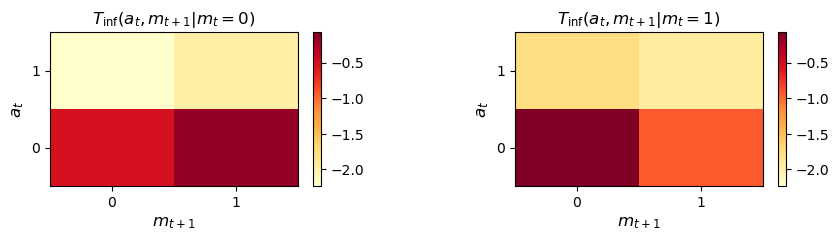

[0.30697952 0.69302048]
[0.87426308 0.12573692]


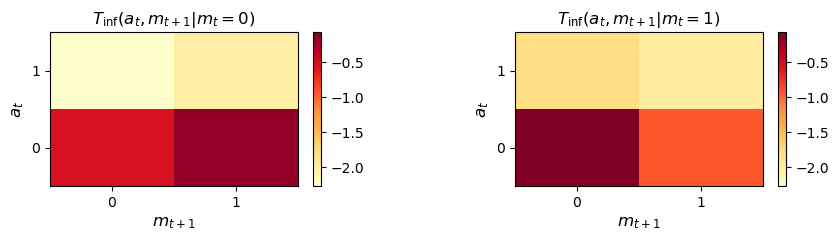

[0.32112942 0.67887058]
[0.86685277 0.13314723]


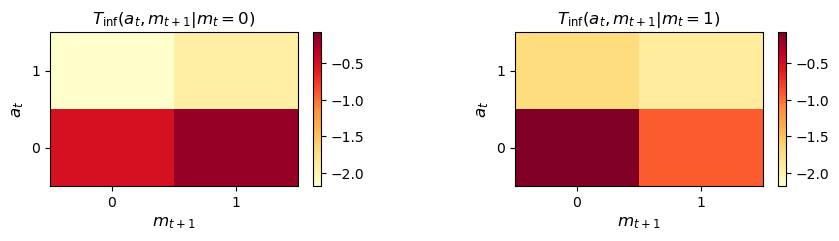

[0.32103612 0.67896388]
[0.86690283 0.13309717]


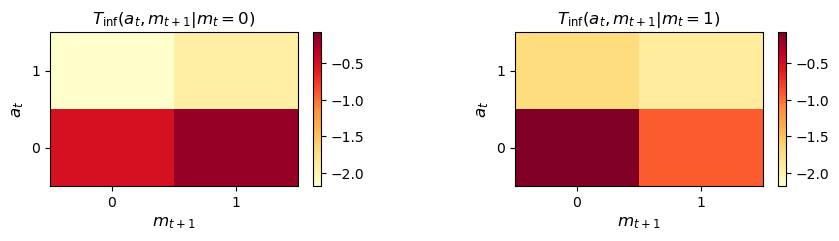

[0.32197873 0.67802127]
[0.86639624 0.13360376]


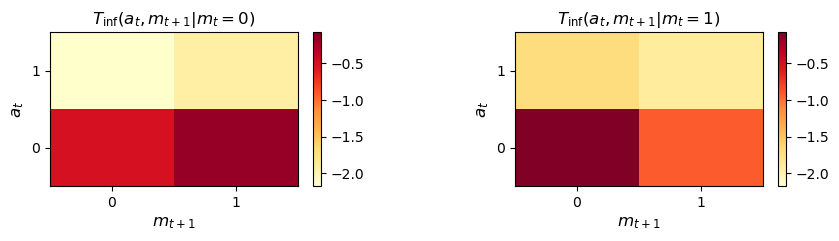

In [353]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20

for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

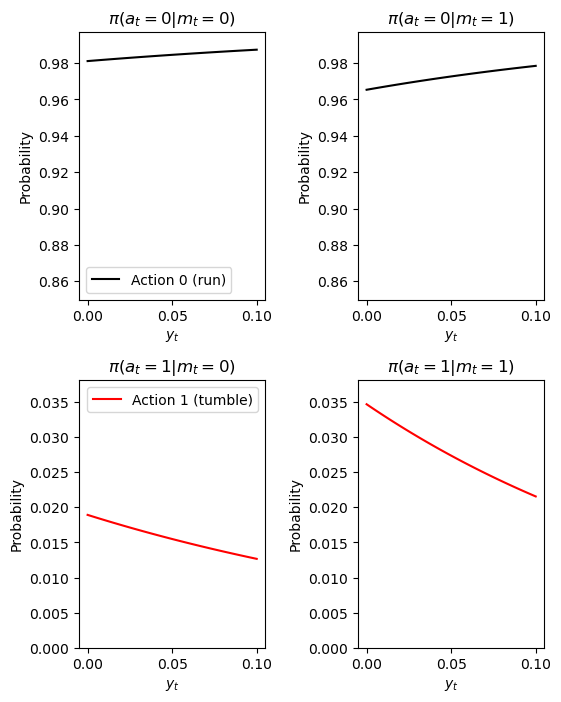

In [354]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

max_p_0 = pi_prob[:, :, 0].max()
max_p_1 = pi_prob[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.85, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, pi_prob[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, pi_prob[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$\\pi(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$y_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

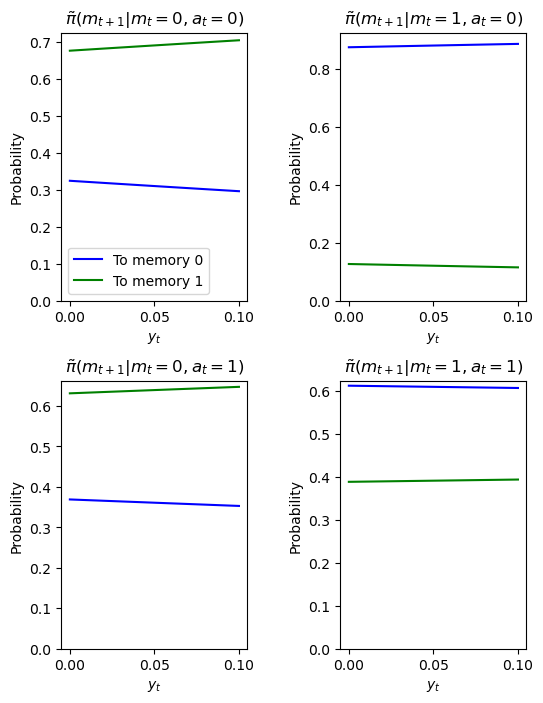

In [355]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_a, a in enumerate(range(A)):
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 0, idx_a], label = f"To memory 0", c = 'b')
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 1, idx_a], label = f"To memory 1", c = 'g')

        ax[idx_a, idx_m].set_title(f"$\\tilde\\pi(m_{{t+1}} | m_t = {m}, a_t = {a})$")
        ax[idx_a, idx_m].set_xlabel("$y_t$")
        ax[idx_a, idx_m].set_ylabel("Probability")
        ax[idx_a, idx_m].set_ylim(0,)

ax[0, 0].legend()

plt.show()

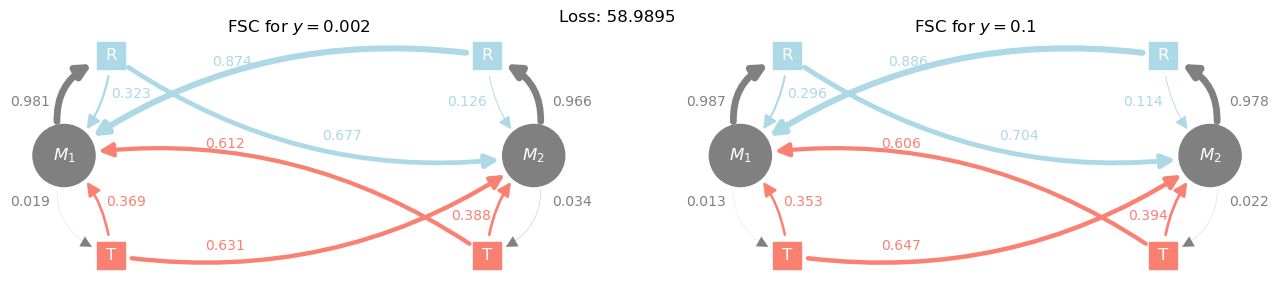

In [356]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

idx_y = 2
plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

idx_y = -1
plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
fig.suptitle(overall_title, fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.show()

# Fourth seed

Initializing FSC with 2 memory states, 2 actions, and 2 features.


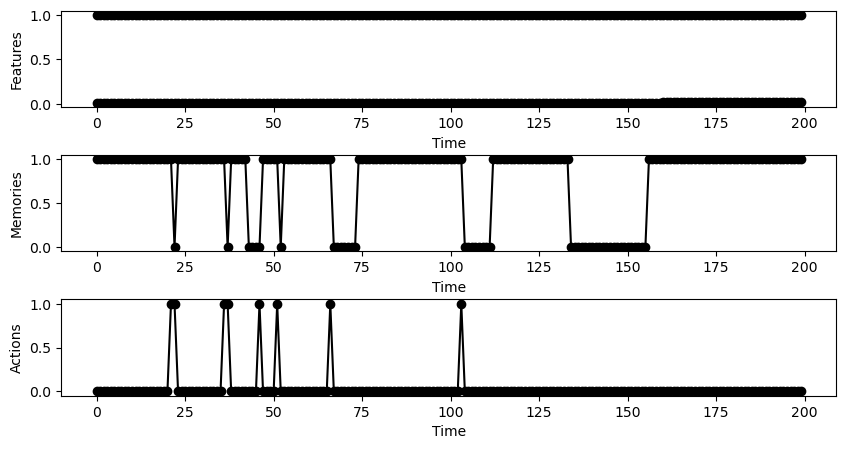

In [359]:
idx_seed = 3
FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = True)

FSC_inferred.load_features([tr["features"] for tr in trajectories])

NSteps = 200
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

In [360]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

pi_prob = TMat_array.sum(axis = 2)
pitilde_prob = TMat_array/pi_prob[:, :, None, :]

[0.81620919 0.18379081]
[0.02889534 0.97110466]


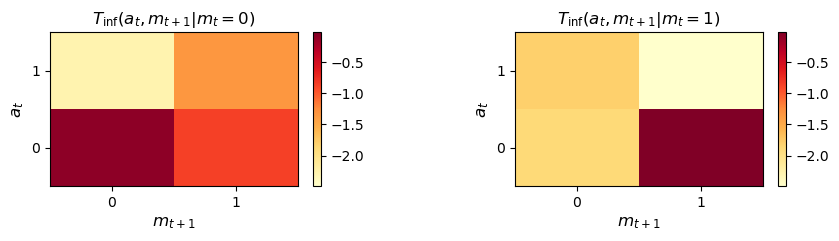

[0.82066563 0.17933437]
[0.02672809 0.97327191]


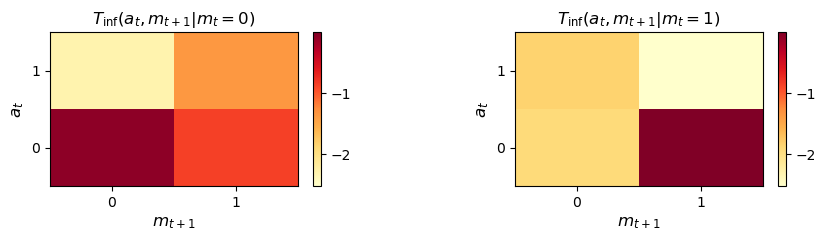

[0.81041145 0.18958855]
[0.03187978 0.96812022]


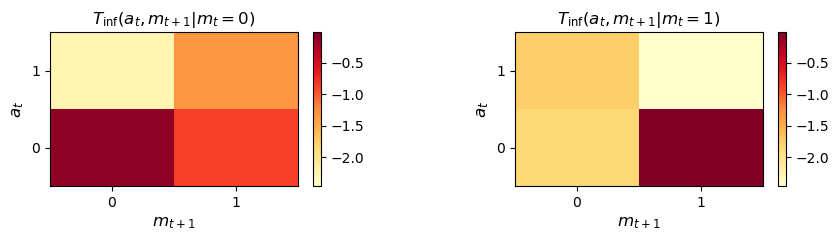

[0.81048022 0.18951978]
[0.03184327 0.96815673]


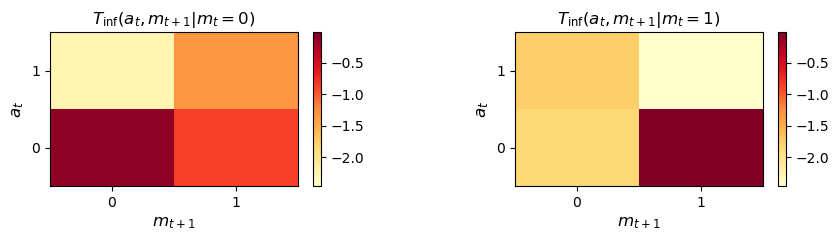

[0.80978468 0.19021532]
[0.03221376 0.96778624]


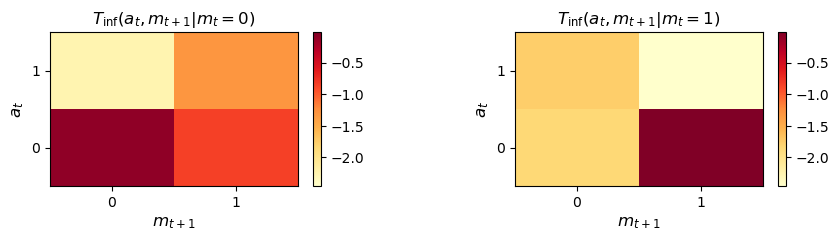

In [361]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20

for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

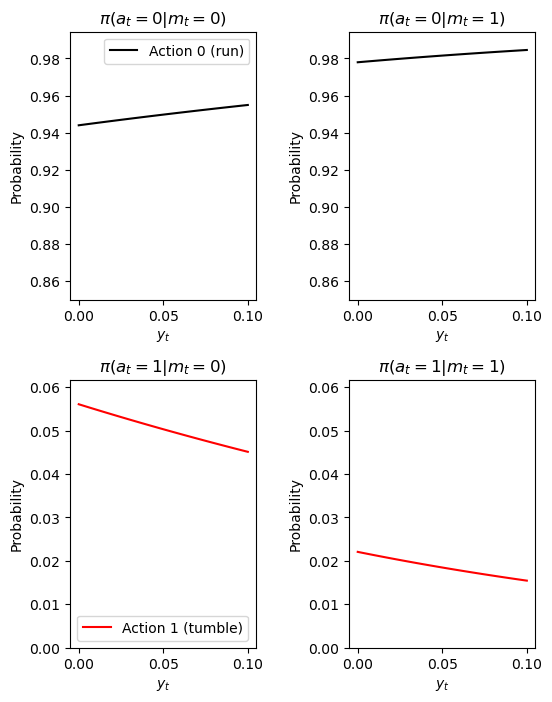

In [362]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

max_p_0 = pi_prob[:, :, 0].max()
max_p_1 = pi_prob[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.85, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, pi_prob[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, pi_prob[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$\\pi(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$y_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

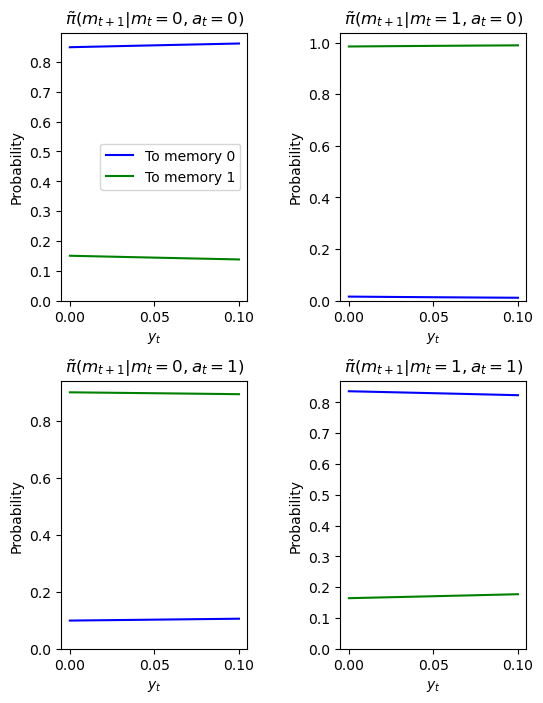

In [363]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_a, a in enumerate(range(A)):
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 0, idx_a], label = f"To memory 0", c = 'b')
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 1, idx_a], label = f"To memory 1", c = 'g')

        ax[idx_a, idx_m].set_title(f"$\\tilde\\pi(m_{{t+1}} | m_t = {m}, a_t = {a})$")
        ax[idx_a, idx_m].set_xlabel("$y_t$")
        ax[idx_a, idx_m].set_ylabel("Probability")
        ax[idx_a, idx_m].set_ylim(0,)

ax[0, 0].legend()

plt.show()

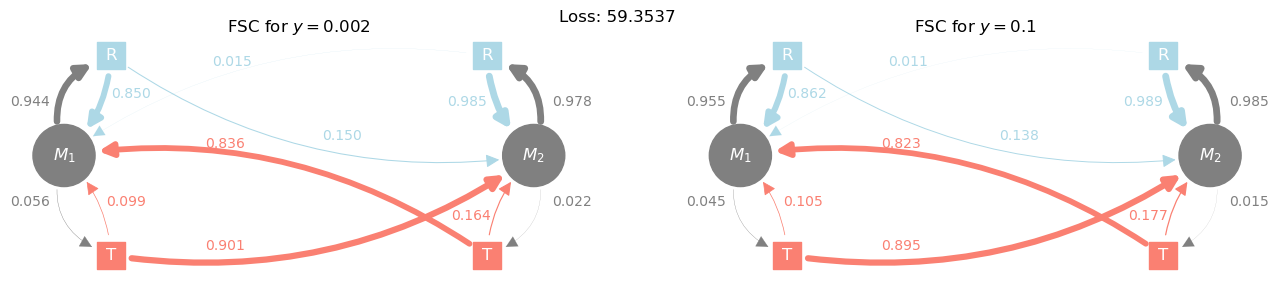

In [364]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

idx_y = 2
plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

idx_y = -1
plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
fig.suptitle(overall_title, fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.show()

# Fifth seed

Initializing FSC with 2 memory states, 2 actions, and 2 features.


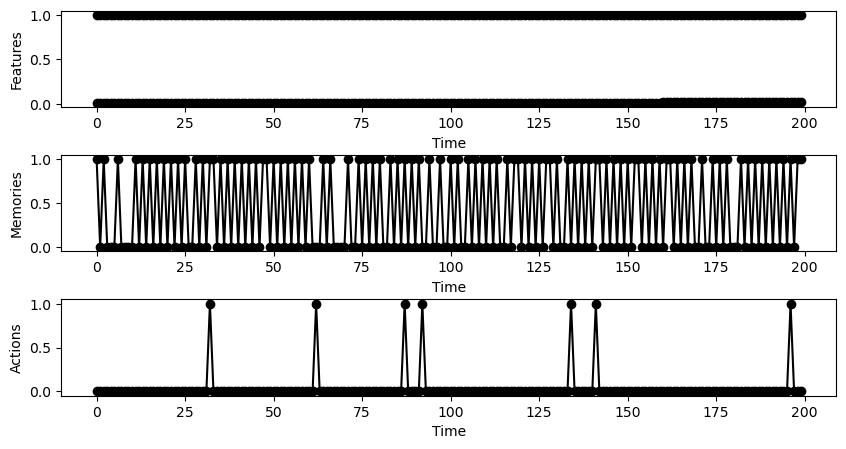

In [366]:
idx_seed = 4
FSC_inferred = FSC_ContinuousObs(theta_list[idx_seed], psi_list[idx_seed], verbose = True)

FSC_inferred.load_features([tr["features"] for tr in trajectories])

NSteps = 200
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

In [367]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

pi_prob = TMat_array.sum(axis = 2)
pitilde_prob = TMat_array/pi_prob[:, :, None, :]

[0.19505086 0.80494914]
[0.93817885 0.06182115]


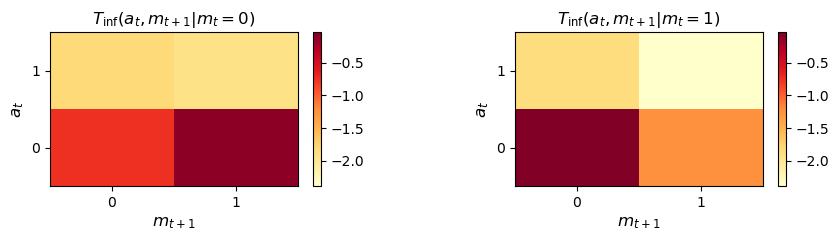

[0.19678319 0.80321681]
[0.93853611 0.06146389]


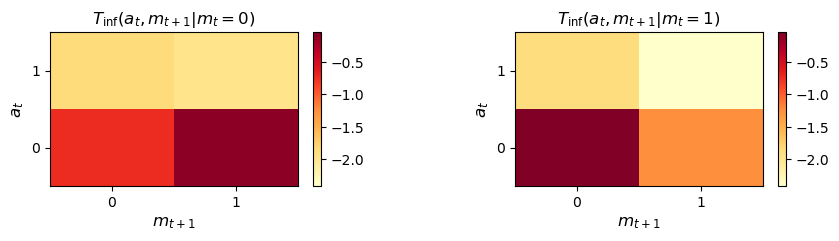

[0.19310975 0.80689025]
[0.93770093 0.06229907]


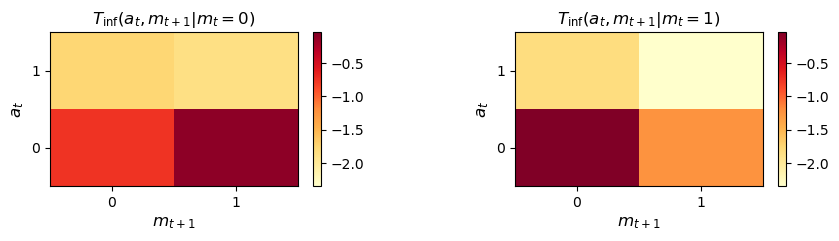

[0.19313071 0.80686929]
[0.93770669 0.06229331]


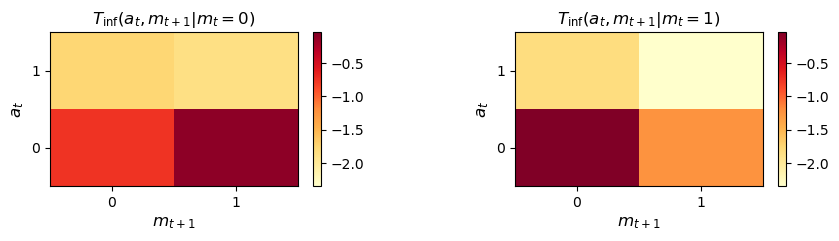

[0.19292102 0.80707898]
[0.93764835 0.06235165]


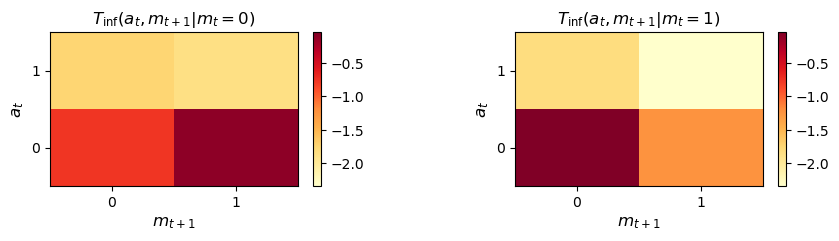

In [368]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20

for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    #rint(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")
        
        print(TMat_inf[idx_m].sum(axis = -1))

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

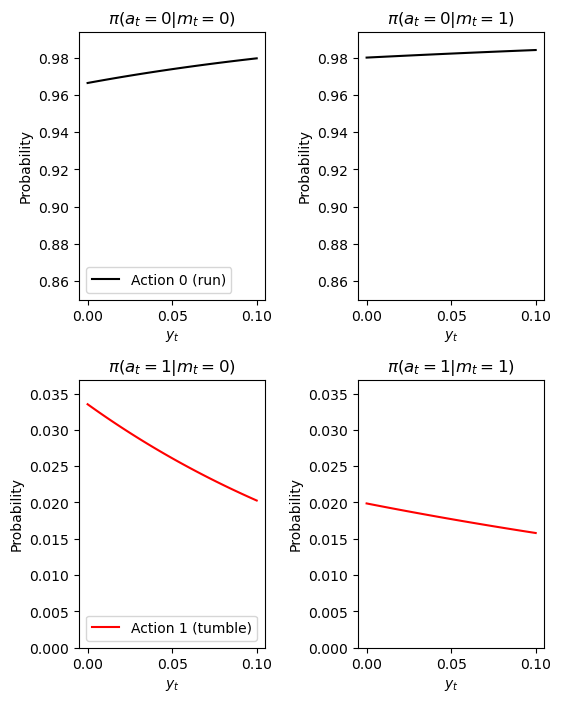

In [369]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

max_p_0 = pi_prob[:, :, 0].max()
max_p_1 = pi_prob[:, :, 1].max()

max_ps = [max_p_0*1.01, max_p_1*1.1]
min_ps = [0.85, 0]

for idx_m, m in enumerate(range(M)):
    ax[0, idx_m].plot(c_array, pi_prob[:, idx_m, 0], label = f"Action 0 (run)", c = 'k')
    ax[1, idx_m].plot(c_array, pi_prob[:, idx_m, 1], label = f"Action 1 (tumble)", c = 'r')

    for i in range(2):
        ax[i, idx_m].set_title(f"$\\pi(a_t = {i} | m_t = {m})$")
        ax[i, idx_m].set_xlabel("$y_t$")
        ax[i, idx_m].set_ylabel("Probability")
        ax[i, idx_m].set_ylim(min_ps[i], max_ps[i])

ax[0, 0].legend()
ax[1, 0].legend()

plt.show()

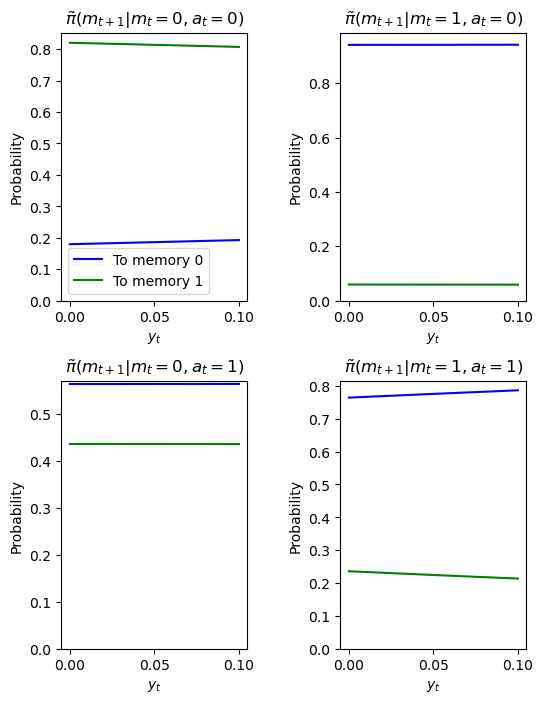

In [370]:
fig, ax = plt.subplots(A, M, figsize=(6,8))
plt.subplots_adjust(hspace = 0.3, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_a, a in enumerate(range(A)):
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 0, idx_a], label = f"To memory 0", c = 'b')
        ax[idx_a, idx_m].plot(c_array, pitilde_prob[:, idx_m, 1, idx_a], label = f"To memory 1", c = 'g')

        ax[idx_a, idx_m].set_title(f"$\\tilde\\pi(m_{{t+1}} | m_t = {m}, a_t = {a})$")
        ax[idx_a, idx_m].set_xlabel("$y_t$")
        ax[idx_a, idx_m].set_ylabel("Probability")
        ax[idx_a, idx_m].set_ylim(0,)

ax[0, 0].legend()

plt.show()

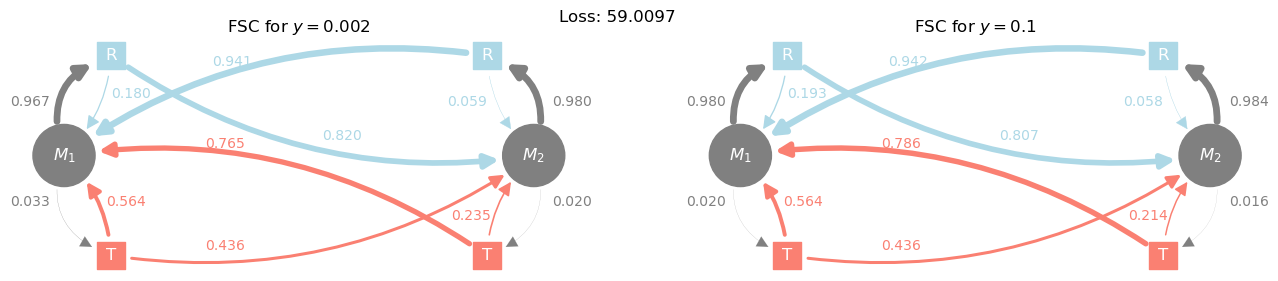

In [371]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))

idx_y = 2
plot_network(ax1, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

idx_y = -1
plot_network(ax2, pi_prob[idx_y], pitilde_prob[idx_y], title=f"FSC for $y = {np.round(c_array[idx_y], 3)}$")

overall_title = f"Loss: {np.round(vloss_list[idx_seed][-1], 4)}"
fig.suptitle(overall_title, fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.show()

# OLD

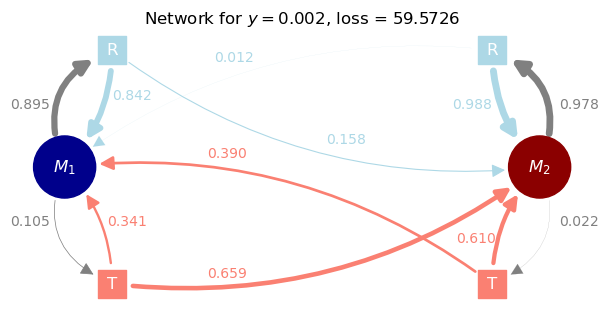

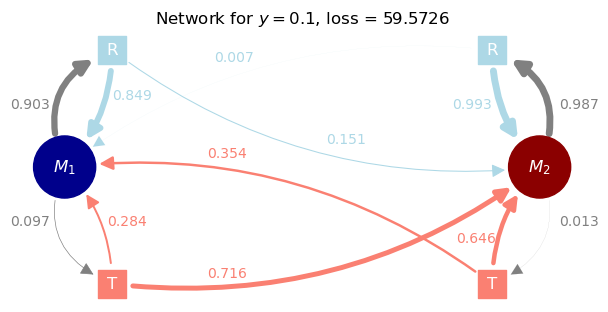

In [256]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_network(piprob, pitilde_prob,
                 memory1_color='darkblue', memory2_color='darkred',
                 action_r_color='lightblue', action_t_color='salmon',
                 figsize=(10, 3), title=""):
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add memory nodes
    G.add_node('$M_1$', shape='o', color=memory1_color)
    G.add_node('$M_2$', shape='o', color=memory2_color)
    
    # Add action nodes
    G.add_node('R1', shape='s', color=action_r_color)
    G.add_node('T1', shape='s', color=action_t_color)
    G.add_node('R2', shape='s', color=action_r_color)
    G.add_node('T2', shape='s', color=action_t_color)
    
    # Add edges from memory nodes to action nodes
    G.add_edges_from([('$M_1$', 'R1'), ('$M_1$', 'T1'),
                      ('$M_2$', 'R2'), ('$M_2$', 'T2')])
    
    # Add edges from action nodes to memory nodes
    G.add_edges_from([('R1', '$M_1$'), ('R1', '$M_2$'),
                      ('T1', '$M_1$'), ('T1', '$M_2$'),
                      ('R2', '$M_1$'), ('R2', '$M_2$'),
                      ('T2', '$M_1$'), ('T2', '$M_2$')])
    
    # Define node shapes
    node_shapes = {'o': 'o', 's': 's'}
    
    # Define custom labels for plotting
    labels = {'$M_1$': '$M_1$', '$M_2$': '$M_2$', 'R1': 'R', 'T1': 'T', 'R2': 'R', 'T2': 'T'}
    
    # Define positions for the nodes
    pos = {
        '$M_1$': (0, 0),
        'R1': (0.2, 1),
        'T1': (0.2, -1),
        '$M_2$': (2, 0),
        'R2': (1.8, 1),
        'T2': (1.8, -1)
    }

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    plt.tight_layout()
    
    # Draw the graph
    for shape in node_shapes:
        nodes = [n for n in G.nodes if G.nodes[n]['shape'] == shape]
        colors = [G.nodes[n]['color'] for n in nodes]
        node_size = 2000 if shape == 'o' else 400  # Larger size for memory nodes, smaller for action nodes
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=node_shapes[shape],
                               node_size=node_size, node_color=colors, ax=ax)
    
    # Draw edges with arrows and curved connections
    memory_to_action_edges_left = [('$M_2$', 'R2', piprob[1, 0]), ('$M_1$', 'T1', piprob[0, 1])]
    memory_to_action_edges_right = [('$M_1$', 'R1', piprob[0, 0]), ('$M_2$', 'T2', piprob[1, 1])]
    memory_to_action_edges = [memory_to_action_edges_left, memory_to_action_edges_right]

    action_to_memory_stay_edges_1 = [('R1', '$M_1$', pitilde_prob[0, 0, 0]), ('T2', '$M_2$', pitilde_prob[1, 1, 1])]
    action_to_memory_stay_edges_2 = [('R2', '$M_2$', pitilde_prob[1, 1, 0]), ('T1', '$M_1$', pitilde_prob[0, 0, 1])]

    action_to_memory_stay_edges = [action_to_memory_stay_edges_1, action_to_memory_stay_edges_2]

    action_to_memory_edges = [('R1', '$M_2$', pitilde_prob[0, 1, 0]), ('T1', '$M_2$', pitilde_prob[0, 1, 1]),
                              ('R2', '$M_1$', pitilde_prob[1, 0, 0]), ('T2', '$M_1$', pitilde_prob[1, 0, 1])]
    
    # Draw edges with different colors and connection styles

    xshifts = {'$M_1$': -0.33, '$M_2$': 0.18}
    pscale = 5
    rads = [0.5, -0.5]

    for i in range(len(memory_to_action_edges)):
        for j, (u, v, prob) in enumerate(memory_to_action_edges[i]):
            width = prob * pscale

            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rads[i]}', width=width,
                                arrows=True, arrowsize=20, min_source_margin=25, min_target_margin=15, edge_color='gray', ax=ax)
            
            x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
            y = (pos[u][1] + pos[v][1]) / 2
            ax.text(x, y, f'{prob:.3f}', fontsize=10, color='gray')

    rads = [-0.2, 0.2]
    xshifts = {'R1': 0.1, 'T1': 0.08, 'R2': -0.27, 'T2': -0.25}
    yshifts = {'R1': 0.08, 'T1': -0., 'R2': 0., 'T2': -0.15}
    colors = {'R1': 'lightblue', 'T1': 'salmon', 'R2': 'lightblue', 'T2': 'salmon'}

    for i in range(len(action_to_memory_stay_edges)):
        for j, (u, v, prob) in enumerate(action_to_memory_stay_edges[i]):
            width = prob * pscale

            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rads[i]}', width=width,
                                   arrows=True, arrowsize=20, min_source_margin=15, min_target_margin=25, edge_color=colors[u], ax=ax)
            
            x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
            y = (pos[u][1] + pos[v][1]) / 2 + yshifts[u]
            ax.text(x, y, f'{prob:.3f}', fontsize=10, color=colors[u])

    xshifts = {'R1': 0., 'T1': -0.5, 'R2': -0.27, 'T2': -0.3}
    yshifts = {'R1': -0.3, 'T1': -0.45, 'R2': 0.4, 'T2': 0.58}

    for i, (u, v, prob) in enumerate(action_to_memory_edges):
        width = prob * pscale

        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], connectionstyle='arc3,rad=0.2', width=width,
                               arrows=True, arrowsize=20, min_source_margin=15, min_target_margin=25, edge_color=colors[u], ax=ax)
        
        x = (pos[u][0] + pos[v][0]) / 2 + xshifts[u]
        y = (pos[u][1] + pos[v][1]) / 2 + yshifts[u]

        ax.text(x, y, f'{prob:.3f}', fontsize=10, color=colors[u])
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='white')
    
    # Add title
    plt.title(title)

    cut = 1.1
    xmax= cut*max(xx for xx,yy in pos.values())
    ax.set_xlim(-0.2,xmax)

    plt.show()

# Call the function to plot the network with a specified figure size and title
idx_y = 2
plot_network(pi_prob[idx_y], pitilde_prob[idx_y], figsize=(6, 3), title=f"Network for $y = {np.round(c_array[idx_y], 3)}$, loss = {np.round(vloss_list[0][-1], 4)}")

idx_y = -1
plot_network(pi_prob[idx_y], pitilde_prob[idx_y], figsize=(6, 3), title=f"Network for $y = {np.round(c_array[idx_y], 3)}$, loss = {np.round(vloss_list[0][-1], 4)}")